A: Plotting SNR for given data to find a 10-Solar-mass binary merger

Text(0, 0.5, 'strain')

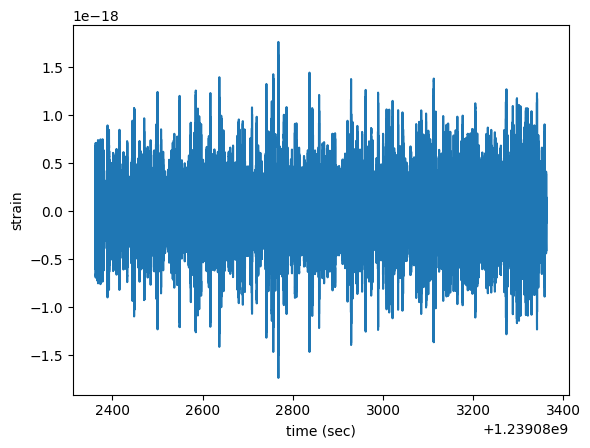

In [27]:
'''
Loading the data and converting the data type into time
series
'''
#!pip install pycbc
#! pip install -q 'gwosc==0.5.4'
%matplotlib inline

import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')
#print(data.delta_t)

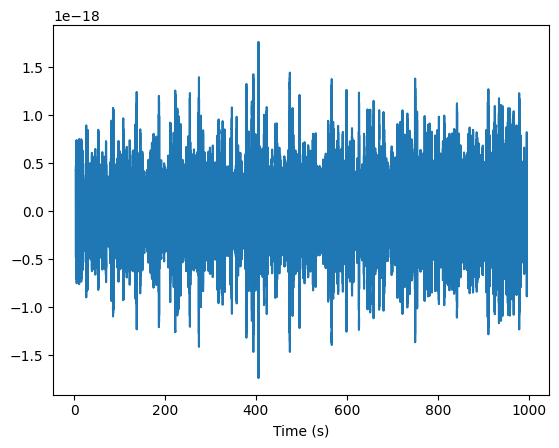

In [28]:
conditioned = data.crop(4, 4)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

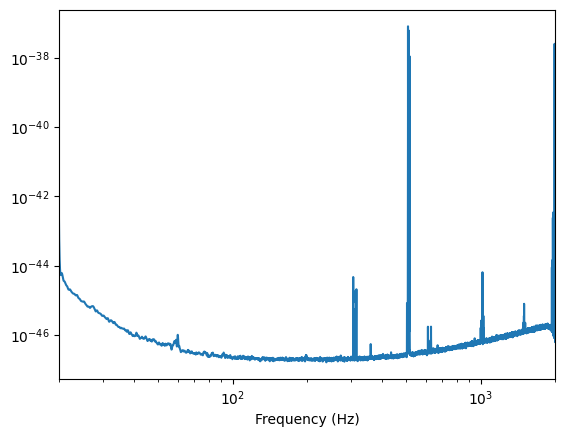

In [29]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
import matplotlib.pyplot as pp
import pycbc.types

# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)
#plot the psd in a log scale.
pp.loglog(psd.sample_frequencies, psd)

pp.xlim(xmin=20, xmax=2000)
pp.xlabel('Frequency (Hz)')
pp.show()

In [30]:
from pycbc.waveform import get_td_waveform

m = 10 # Solar masses
hp, hc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t, #delta_t needs to match data
                     f_lower=20)

# Resize the vector to match data
hp.resize(len(conditioned))

#shift waveform for use as template signal in SNR
template = hp.cyclic_time_shift(hp.start_time)

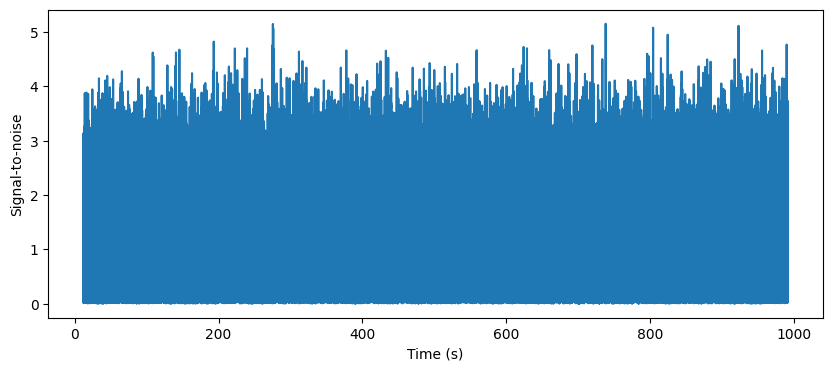

Found a signal at 738.473388671875s with SNR 5.155292902901349


In [31]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)


pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("Found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

No outstanding SNR-value found. Signal could not be placed in the data.

##B:Whitening process of the data.

In [32]:
import pycbc.psd
#print(psd)
#print(len(psd))
#print(data.to_frequencyseries())
#print(len(conditioned.to_frequencyseries()))
#print(len(conditioned))
#help(data.to_timeseries())
#print(data)


#Find optimal SNR
#First part. Division (this might take a minute or two)
data_ft = conditioned.to_frequencyseries()

for i in range(len(psd)):
    data_ft[i] = (data_ft[i] / (psd[i]**0.5))

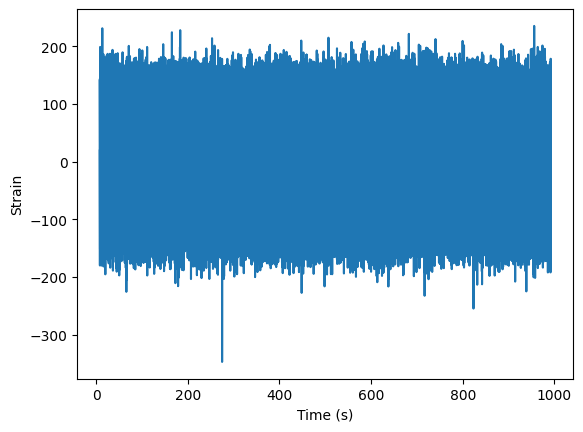

In [33]:
#print(type(data_ft))
#print(len(data_ft))
#print(len(psd))

#convert quotient back into timeseries data. Then crop anomalies out and plot.
white_data = data_ft.to_timeseries()
crp_white_data = white_data.crop(4, 4)

pylab.plot(crp_white_data.sample_times, crp_white_data)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

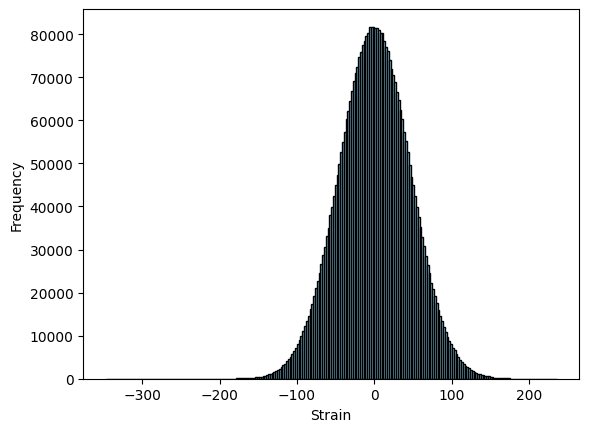

In [34]:
#plot histogram of the whitened data.
plt.hist(crp_white_data, bins=250, color='skyblue', edgecolor = 'black')

plt.xlabel('Strain')
plt.ylabel('Frequency')
plt.show()

Whitened data shows a Gaussian distribution with mean 0 (zero)

##C: Check stationary-Gaussian assumption by comparing result of various SNR analyses at different chunks of the data.

In [35]:
from pycbc.waveform import get_fd_waveform
hp2, hc2 = get_fd_waveform(approximant="TaylorF2",
                            mass1=3,
                            mass2=3,
                            delta_f=conditioned.delta_f ,
                            distance = 500,
                            f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc



In [36]:
from pycbc.filter import sigmasq
#help(conditioned)
#print(conditioned.get_duration())
#print(len(conditioned))
#print(conditioned.sample_rate)
#print(conditioned.get_duration()*conditioned.sample_rate == len(conditioned))



#Divide (conditioned) data into equal time intervals (of 8 seconds) and make a psd analysis of each chunk (chose a large amount of chunks: this might take more than a minute)
chnk = []
psd_chnks = []
SNR = []
chnk_lgth = int(conditioned.get_duration()*conditioned.sample_rate/124 - 1)
strt = 0
print('Data has been cut into 124 chunks of {} seconds'.format((chnk_lgth + 1)/conditioned.sample_rate))
#print(type(chnk_lgth))



for i in range(124):
  strt = i * chnk_lgth #first datapoint index in current chunk
  chnk = conditioned[strt : strt + chnk_lgth] #slice data to get chunk
  psd_chnks.append(chnk.psd(4)) #produce psd of chunk
  psd_chnks[i] = interpolate(psd_chnks[i], conditioned.delta_f)
  psd_chnks[i] = inverse_spectrum_truncation(psd_chnks[i], int(4 * conditioned.sample_rate),
                                              low_frequency_cutoff=20)

  SNR.append((pycbc.filter.sigmasq(hp2, psd_chnks[i]))**0.5) #produce SNR analysis of chunk to compare

Data has been cut into 124 chunks of 7.999755859375 seconds


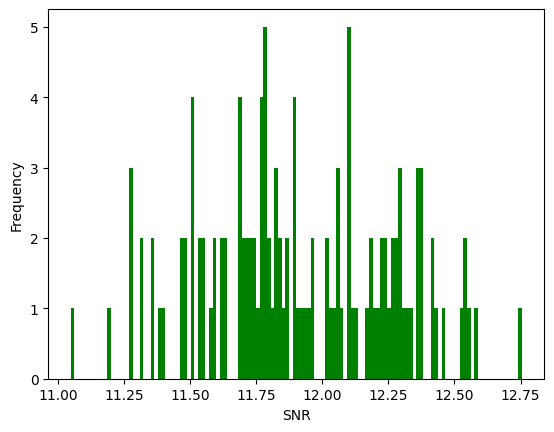

In [37]:
#plot histogram of chunked-data SNR analysis
plt.hist(SNR, bins = 124, color='green')

plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.show()

A non-gaussian distribution of the SNR in various chunks of the (conditioned) data, showing the stationary assumption was not valid.